次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業価値の変動

・企業価値に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [77]:
using StatsPlots
using Random
using Statistics

In [78]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業価値
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms, ft)
    σ_r, σ, μ = 0.02, 2.0, log(100.0*ft)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.02*firms[i].hiddenCorporateValue + 0.98*estimated_value) * exp(0.1*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_ln_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_ln_amp += log(marketCap/fundamentals)
        fundamentals_sum += fundamentals
    end
    mean_ln_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = min(firms[i].stockPrice, (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity))
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p > β2
            push!(buy, (p,i))
        end
    end
    for (i, q) in enumerate(agent.sharesQuantity)
        if q == 0.0
            continue
        end
        x1, x2, x3, x4, x5, x6 = firms[i].stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p < β1
            push!(sell, (p,i))
        end
    end
    #   売り
    going_to_sell_price = 0.0
    for (p, i) in sell
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        end
        going_to_sell_price += price * quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
    #   買い
    sort!(buy)
    if size(buy)[1] > Integer(agent.params[end])
        buy = buy[end-Integer(agent.params[end])+1:end]
    end
    marketCap_sum = 0
    for (_, i) in buy
        marketCap_sum += firms[i].marketCapitalization
    end
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    buy_target = max(0.0, agent.money + going_to_sell_price - agent.portfolio_target[1])
    if buy_target == 0.0
        return nothing
    end
    for k in 1:min(Integer(agent.params[end]), size(buy)[1])
        _, i = buy[k]
        allocations_lst[i] = buy_target*firms[i].marketCapitalization/marketCap_sum
    end
    for (p, i) in buy
        price = (1+p)*firms[i].stockPrice
        if price <= 0.0
            continue
        end
        quantity = allocations_lst[i]/price
        push!(firms[i].buy_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        t0, t1 = agent.total_assets_log[end-9], agent.total_assets_log[end]
        if rand() < 0.01 - 0.01*(t1 - t0)/t0
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/(std(agent.params[3:7])*sqrt(5))
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income, ft)
    update_hiddenCorporateValue(firms, ft)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end
function f(t)
    return 2^(0.01*t)
end

f (generic function with 1 method)

In [79]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
];

In [80]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [81]:
T = 10^3
income_lst = [0.0002*init_money*f(t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income, f(t))
end

 12.844326 seconds (78.21 M allocations: 1.751 GiB, 5.00% gc time, 10.79% compilation time)


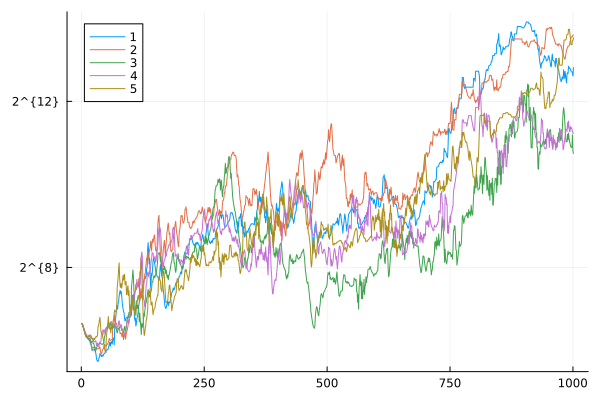

In [82]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

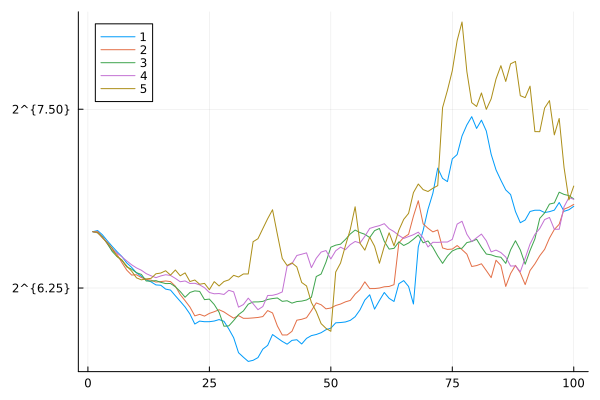

In [83]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

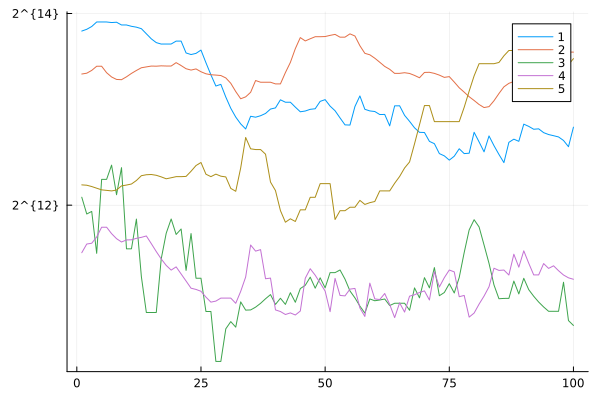

In [84]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log2)

・企業価値/時価総額が相対的に大きいときは、fundamental戦略をとるエージェントが売買の中心になっていて、価格変動が安定しやすい

・企業価値/時価総額が相対的に小さいときは、chart戦略をとるエージェントが売買の中心になっていて、価格変動が変動しやすい

かもしれない

In [85]:
tmp = 0.0
for i = 1:10
    for t = 1:99
        tmp += 100*(firms[i].stockPriceLog[end-t] - firms[i].stockPriceLog[end-1-t])/firms[i].stockPriceLog[end-1-t]
    end
    tmp /= 99
    println("「会社$i","の直近１００期の株価の平均変動率」は $tmp"," %")
end

「会社1の直近１００期の株価の平均変動率」は -0.6907683160122268 %
「会社2の直近１００期の株価の平均変動率」は 0.17073855727628948 %
「会社3の直近１００期の株価の平均変動率」は 0.2716284117469224 %
「会社4の直近１００期の株価の平均変動率」は 0.2232471703299795 %
「会社5の直近１００期の株価の平均変動率」は 1.1081303828625697 %
「会社6の直近１００期の株価の平均変動率」は 0.2633872570531668 %
「会社7の直近１００期の株価の平均変動率」は 0.13550656192557867 %
「会社8の直近１００期の株価の平均変動率」は 0.9117318965883573 %
「会社9の直近１００期の株価の平均変動率」は 0.03653355500536048 %
「会社10の直近１００期の株価の平均変動率」は 0.054357608864996666 %


In [86]:
for i = 1:10
    println(i, agents[i].portfolio_target,agents[i].portfolio_target[2]/sum(agents[i].portfolio_target))
end

1[2441.5368687504815, 477.20922439516755]0.16349802592141893
2[3743.279088468946, 792.3930193136806]0.17470244772633292
3[1923.4459557675307, 848.570764984349]0.30612036306699597
4[6918.497508402929, 1680.5797080494308]0.19543721561588345
5[502.8789739908704, 2349.0893957266644]0.8236730184911986
6[3038.199222576462, 467.8442160372826]0.1334393666902951
7[2814.007733616135, 883.5926272906792]0.2389637984224946
8[2331.190291828213, 629.9227514431211]0.21273174723083332
9[2545.3317668618615, 473.3918424844646]0.15681854444003662
10[1500.9601300758875, 1781.2988535553873]0.5427051498491675


In [87]:
agents

100-element Vector{Agent}:
 Agent("fundamentals", 2937.1780931456487, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [100.0, 100.67831408429444, 101.19357677060727, 101.67551016952814, 102.14876845636488, 102.64080410407138, 103.20645903149008, 103.77009580342866, 104.40321940597454, 105.11389807226949  …  2758.483184044656, 2775.8004673581686, 2793.238201902615, 2810.797225482561, 2828.478381729964, 2846.2825201447067, 2864.21049613541, 2882.263171060532, 2900.4414122697535, 2918.746093145649], [0.8365019740785811, 72.0], [504.3386266068283, 236.3265706592213, 57.22401315201699, 61.75189697514737, 73.38745633320192, 48.46102173967778, 108.42400687914012, 87.65323599177668, 128.40631961612692, 85.1054063184418], [2441.5368687504815, 477.20922439516755], [12.824931152191454, 9.977741992700958, 3.4826215798104703, 4.60794092852064, 4.596821679209239, 5.628531191903712, 6.641600166928844, 4.84138334225621, 11.458562210998144, 6.1264

In [88]:
firms

10-element Vector{Firm}:
 Firm(72.0151412082578, 100.0, [1.0, 1.0054387771208761, 0.9845523197718025, 0.9566584606913024, 0.9310397373352122, 0.9074591499662539, 0.8862793519126597, 0.8592900244371711, 0.8411488091789434, 0.8190217890343212  …  72.42958594154591, 70.94037602549912, 71.1526287403332, 69.22003189738288, 68.27668664120631, 67.70846309434795, 67.10250671252166, 65.41431992677349, 62.52834796410785, 72.0151412082578], [100.0], 7201.51412082578, 193.9134713601311, Any[(57.60694310290884, 1.04727475460257, 95), (61.05234106948628, 3.310403764241361, 75), (64.67629879491975, 0.2369955353650517, 30), (65.71912709975255, 0.05211298728098257, 26), (68.62565235602581, 0.10833568959927131, 79), (74.2145417885291, 0.10568666519747034, 76)], Any[])
 Firm(123.92017269574484, 100.0, [1.0, 1.0, 0.9748120070127395, 0.9425373207812782, 0.9129120744777635, 0.8957829644490736, 0.8605352951391645, 0.8298345698187315, 0.8104294631003044, 0.8115436206507312  …  103.52347772649989, 105.57319711

In [89]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

343195.78594468464

In [90]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

193.9134713601311


342.16240855880153
22.749567065822514
83.52006113489736
71.57850120621417
89.72082966122562
62.474862807272125
105.1605871600158
58.56767118268032
91.60661793524113


In [91]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

7201.51412082578
12392.017269574484
1716.4676336241318
2397.3119501422098
11821.49551813159
5266.9450869556285
2271.1566781275233
4491.6097391653775
4959.512103910878
4166.605389263926


In [92]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[504.3386266068283, 236.3265706592213, 57.22401315201699, 61.75189697514737, 73.38745633320192, 48.46102173967778, 108.42400687914012, 87.65323599177668, 128.40631961612692, 85.1054063184418]
[118.38156628572173, 245.1151843252307, 24.50958679640823, 83.82983114878989, 158.38820703444563, 118.31312407577566, 79.93284634450623

, 61.45496453709485, 62.437759506406415, 161.4246811022404]
[195.4970267988706, 296.49777573138067, 42.24013337982326, 71.77168878652918, 224.83591162199943, 82.53331195552177, 126.97116607173305, 65.40738300194845, 45.5449053786769, 92.99794527406712]
[320.47357820309094, 313.90490622525635, 24.635669653794004, 132.9601175408148, 142.54242806760385, 237.83768280693334, 74.60502371361784, 114.55024202184659, 39.96255848177358, 143.68943393479228]
[167.4728336888232, 431.58614120450227, 37.693115585515635, 72.28439913545877, 79.05291779263284, 52.65830193305885, 38.54136029714475, 68.64115391717536, 176.8458028685206, 67.24768687941135]
[516.3710491500639, 367.70223166663953, 58.85120428595982, 91.72607044642126, 110.51514298015707, 53.24475618207972, 73.30732552524442, 78.7347181639176, 169.5298208775773, 77.29348219690429]
[173.3555271091023, 268.2002548683049, 30.025775212200454, 42.740545436736994, 78.56744431294003, 106.7655753043831, 59.15518940947861, 96.56859935119911, 70.977096

In [93]:
for agent in agents[1:10]
    println(agent.params)
end

[0.8365019740785811, 72.0]
[0.8252975522736671, 35.0]
[0.693879636933004, 3.0]
[0.8045627843841165, 24.0]
[0.17632698150880147, 31.0]
[0.8665606333097049, 4.0]
[0.7610362015775054, 8.0]
[0.7872682527691667, 33.0]
[0.8431814555599634, 11.0]
[0.45729485015083243, 13.0]


In [94]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 3.8578164471757885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 2.742539195325914, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.4376813633748218, 0.0, 0.0, 0.0, 1.3578294031036617, 0.0, 0.0, 2.226803192475753, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [95]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
